In [1]:
# @title
import datetime
print(datetime.datetime.now())

2024-04-09 04:12:09.214511


# Static Analysis

**Static program analysis** is the analysis of computer software performed without executing any programs, in contrast with **dynamic analysis**, which is performed on programs during their execution.

We only focus on binary analysis here, not symbolic analysis.

[Wiki] The Portable Executable (PE) format is a file format for executables, object code, DLLs and others used in 32-bit and 64-bit versions of Windows operating systems. The PE format is a data structure that encapsulates the information necessary for the Windows OS loader to manage the wrapped executable code. This includes dynamic library references for linking, API export and import tables, resource management data and local storage data.

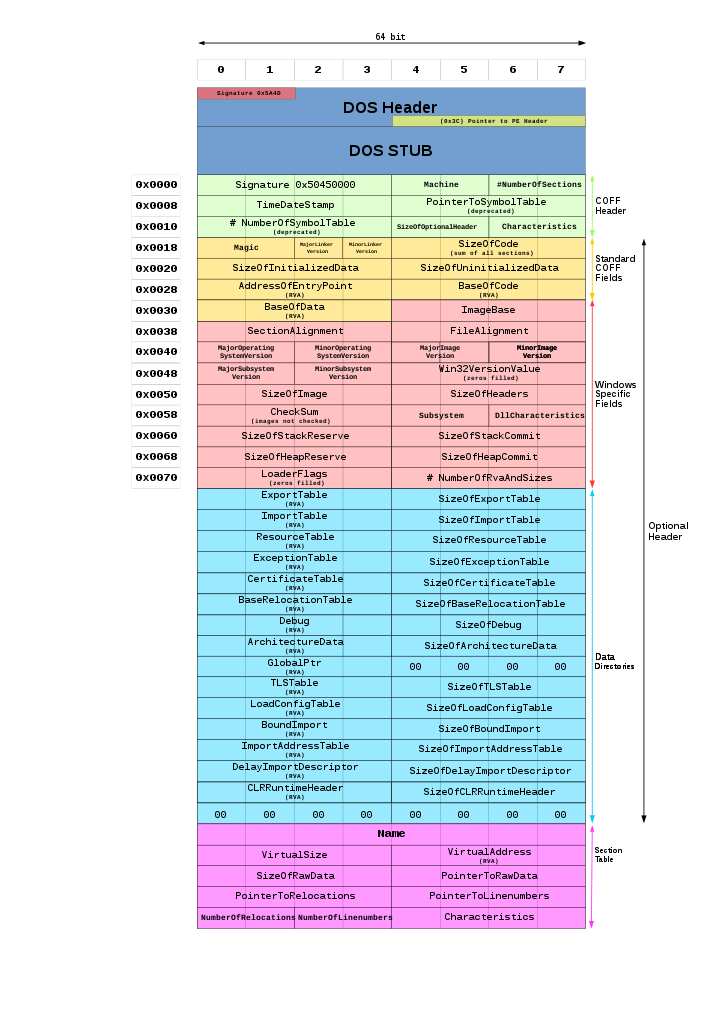

### Get Example Files

In [2]:
# Get a 32-bit pe file
!wget https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe -O putty32.exe

--2024-04-09 04:12:09--  https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.80/w32/putty.exe [following]
--2024-04-09 04:12:09--  https://the.earth.li/~sgtatham/putty/0.80/w32/putty.exe
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 1489184 (1.4M) [application/x-msdos-program]
Saving to: ‘putty32.exe’

putty32.exe         100%[===================>]   1.42M  2.44MB/s    in 0.6s    

2024-04-09 04:12:10 (2.44 MB/s) - ‘putty32.exe’ saved [1489184/1489184]



In [3]:
# Get a 64-bit pe file
!wget https://the.earth.li/~sgtatham/putty/latest/w64/putty.exe -O putty64.exe

--2024-04-09 04:12:10--  https://the.earth.li/~sgtatham/putty/latest/w64/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.80/w64/putty.exe [following]
--2024-04-09 04:12:11--  https://the.earth.li/~sgtatham/putty/0.80/w64/putty.exe
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 1661216 (1.6M) [application/x-msdos-program]
Saving to: ‘putty64.exe’

putty64.exe         100%[===================>]   1.58M  2.71MB/s    in 0.6s    

2024-04-09 04:12:11 (2.71 MB/s) - ‘putty64.exe’ saved [1661216/1661216]



In [4]:
!ls -al

total 3096
drwxr-xr-x 1 root root    4096 Apr  9 04:12 .
drwxr-xr-x 1 root root    4096 Apr  9 04:11 ..
drwxr-xr-x 4 root root    4096 Apr  5 13:20 .config
-rw-r--r-- 1 root root 1489184 Dec 16 13:19 putty32.exe
-rw-r--r-- 1 root root 1661216 Dec 16 13:19 putty64.exe
drwxr-xr-x 1 root root    4096 Apr  5 13:21 sample_data


### EXE file?

using file extension is a stupid way

In [5]:
def isExe(fp):
    if fp.endswith("exe"):
        return True
    else:
        return False

In [6]:
isExe("putty32.exe")

True

### MZ (DOS) file?

In [7]:
def isMZ(fp):
    with open(fp, 'rb') as hnd:
        if hnd.read(2) == b"MZ":
            return True
        else:
            return False

In [8]:
isMZ("putty32.exe")

True

In [9]:
isMZ("putty64.exe")

True

### PE file?

In [10]:
def isPE(fp):
  try:
    with open(fp, 'rb') as hnd:
      if hnd.read(2) != b"MZ":
        return False
      hnd.seek(0x3c, 0)

      import struct
      offset = struct.unpack('<i', hnd.read(4))[0]
      hnd.seek(offset, 0)
      if hnd.read(4) == b"PE\0\0":
        return True
      else:
        print("isMZ, not PE.")
        return False
  except:
    return False

In [11]:
isPE("/content/putty32.exe")

True

### Architecture? (Machine)

In [12]:
def machine(fp):
  try:
    with open(fp, 'rb') as hnd:
      hnd.seek(0x3c, 0)

      import struct
      offset = struct.unpack('<i', hnd.read(4))[0]
      hnd.seek(offset, 0)
      hnd.read(4)
      machine = struct.unpack("<H", hnd.read(2))[0]

      if machine == 332: # IMAGE_FILE_MACHINE_I386
        return "IA-32 (32-bit x86)"
      elif machine == 512: #IMAGE_FILE_MACHINE_IA64:
        return "IA-64 (Itanium)"
      elif machine == 34404: #IMAGE_FILE_MACHINE_AMD64:
        return "AMD64 (64-bit x86)"
      else:
        return "Unknown architecture"
  except:
    return "Exception"

In [13]:
machine("/content/putty32.exe")

'IA-32 (32-bit x86)'

In [14]:
machine("/content/putty64.exe")

'AMD64 (64-bit x86)'

Microsoft has a mapping table of all machine types and their values. https://docs.microsoft.com/en-us/windows/win32/debug/pe-format

### Hex representation

In [15]:
import binascii

def printHex(fp, limit = 64):
  with open(fp, 'rb') as f:
    content = f.read()

    i = 0
    for b in content:
      print(format(b, "02x"), " ", end="")
      if i% 8 == 7:
        print("")
      i += 1
      if i == limit:
        break

In [16]:
printHex("/content/putty32.exe", limit = 160)

4d  5a  78  00  01  00  00  00  
04  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
40  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  00  00  00  00  
00  00  00  00  78  00  00  00  
0e  1f  ba  0e  00  b4  09  cd  
21  b8  01  4c  cd  21  54  68  
69  73  20  70  72  6f  67  72  
61  6d  20  63  61  6e  6e  6f  
74  20  62  65  20  72  75  6e  
20  69  6e  20  44  4f  53  20  
6d  6f  64  65  2e  24  00  00  
50  45  00  00  4c  01  08  00  
b9  a2  7d  65  00  00  00  00  
00  00  00  00  e0  00  02  01  
0b  01  0e  00  00  6e  0c  00  
00  ee  09  00  00  00  00  00  


Question: where are the DOS and PE signatures?

### Hash

[Wiki] A hash function is any function that can be used to map data of arbitrary size to fixed-size values. The values returned by a hash function are called hash values, digests, or simply hashes. A good hash function should map the expected inputs as evenly as possible over its output range.

Please watch the video.
https://www.youtube.com/watch?v=l53cqhIPZho

In [17]:
import hashlib

#### MD5 and SHA265

You can check it against with the announced hash values at the end of this page. https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html

In [18]:
filenamepath = "putty32.exe"
md5_value = hashlib.md5(open(filenamepath, 'rb').read()).hexdigest()
print(md5_value)

1575e4f6e0f70b34b4d2ac25a2f3fadf


In [19]:
sha256_value = hashlib.sha256(open(filenamepath, 'rb').read()).hexdigest()
print(sha256_value)

88e0276d9908f308bbe7cb829d1001f520ec69ff0f896e1a290f1fa8b178e468


#### GPG

Check the calculated (GNU Privacy Guard) GPG value against with the value in [PuTTY web page](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html). Google "digital signature" first.

* Signature ([here](https://www.chiark.greenend.org.uk/~sgtatham/putty/latest.html))
* Public Key ([here](https://www.chiark.greenend.org.uk/~sgtatham/putty/keys.html))



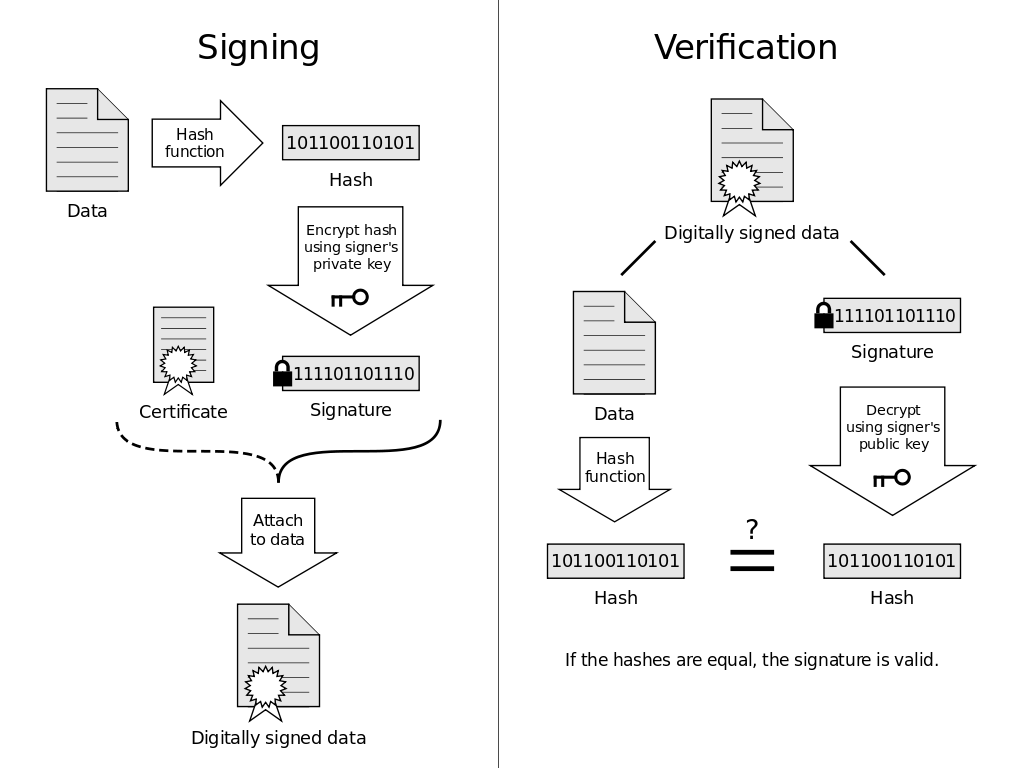

In [20]:
!wget https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe.gpg

--2024-04-09 04:12:12--  https://the.earth.li/~sgtatham/putty/latest/w32/putty.exe.gpg
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://the.earth.li/~sgtatham/putty/0.80/w32/putty.exe.gpg [following]
--2024-04-09 04:12:13--  https://the.earth.li/~sgtatham/putty/0.80/w32/putty.exe.gpg
Reusing existing connection to the.earth.li:443.
HTTP request sent, awaiting response... 200 OK
Length: 438 [application/pgp-signature]
Saving to: ‘putty.exe.gpg’

putty.exe.gpg       100%[===================>]     438  --.-KB/s    in 0s      

2024-04-09 04:12:13 (173 MB/s) - ‘putty.exe.gpg’ saved [438/438]



In [67]:
!wget https://www.chiark.greenend.org.uk/~sgtatham/putty/keys/release-2023.asc

--2024-04-09 04:19:05--  https://www.chiark.greenend.org.uk/~sgtatham/putty/keys/release-2023.asc
Resolving www.chiark.greenend.org.uk (www.chiark.greenend.org.uk)... 212.13.197.231, 2001:ba8:1e3::
Connecting to www.chiark.greenend.org.uk (www.chiark.greenend.org.uk)|212.13.197.231|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2090 (2.0K) [application/pgp-keys]
Saving to: ‘release-2023.asc’

release-2023.asc    100%[===================>]   2.04K  --.-KB/s    in 0s      

2024-04-09 04:19:06 (522 MB/s) - ‘release-2023.asc’ saved [2090/2090]



In [68]:
!gpg --import release-2023.asc

gpg: key 1993D21BCAD1AA77: 1 signature not checked due to a missing key
gpg: key 1993D21BCAD1AA77: public key "PuTTY Releases <putty@projects.tartarus.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1
gpg: no ultimately trusted keys found


In [69]:
!gpg --verify putty.exe.gpg putty32.exe

gpg: Signature made Mon 18 Dec 2023 02:13:26 PM UTC
gpg:                using RSA key F412BA3AA30FDC0E77B4E3871993D21BCAD1AA77
gpg: Good signature from "PuTTY Releases <putty@projects.tartarus.org>" [unknown]
gpg: WARNING: This key is not certified with a trusted signature!
gpg:          There is no indication that the signature belongs to the owner.
Primary key fingerprint: F412 BA3A A30F DC0E 77B4  E387 1993 D21B CAD1 AA77


Note: you may need to change the keyname from release-20xx.asc to correct name, since the key may be expired.

# Virustotal

https://www.virustotal.com/gui/home/upload

Try to search 'loadmony', pick one of them and read its info.

# pefile


In [24]:
!pip install pefile

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.8/71.8 kB 752.3 kB/s eta 0:00:00


In [25]:
import pefile

### File Type

In [26]:
filenamepath = "putty32.exe"

pef = pefile.PE(filenamepath, fast_load = False)

In [27]:
print(pef.is_dll())
print(pef.is_driver())
print(pef.is_exe())

False
False
True


### Machine, Timestamp, imphash

In [28]:
print(pef.FILE_HEADER.Machine)

332


In [29]:
import time
timestamp = pef.FILE_HEADER.TimeDateStamp
print(time.strftime("%Y-%m-%d %H:%M:%S", time.localtime(timestamp)))

2023-12-16 13:14:33


In [30]:
print(pef.get_imphash())

1bcee876dfae5e68c3451c29f9217c72


### Section and Entropy

In [31]:
def printSecEntropy(filenamepath):
  try:
    pef = pefile.PE(filenamepath, fast_load = False)

    total_size = 0
    accumulated_entropy = 0.0

    for sec in pef.sections:
      e = sec.get_entropy()
      m = sec.get_hash_md5()

      print(sec.Name, hex(sec.VirtualAddress), hex(sec.Misc_VirtualSize), sec.SizeOfRawData, e, m)

      accumulated_entropy += sec.SizeOfRawData*e
      total_size += sec.SizeOfRawData
    print('entropy', accumulated_entropy/total_size if total_size !=0 else 'None')
  except:
    print("Error")

In [32]:
printSecEntropy("putty32.exe")

b'.text\x00\x00\x00' 0x1000 0xc6c3a 814592 6.564998062549389 7c0d58b9d7a56230df2daa7e74150bd9
b'.rdata\x00\x00' 0xc8000 0x38ec4 233472 5.693065553278475 e09ae5c1b4d5a58cd16ba1f61dc0edb1
b'.data\x00\x00\x00' 0x101000 0x40d8 3072 2.3398304310066442 c9e17603c1c14cf57daa5e27d0a98278
b'.00cfg\x00\x00' 0x106000 0x8 512 0.06116285224115448 80c010608f3e2c37f435434c4bef7f36
b'.tls\x00\x00\x00\x00' 0x107000 0x9 512 0.0 bf619eac0cdf3f68d496ea9344137e8b
b'.voltbl\x00' 0x108000 0x92 512 2.4564278945748805 03a5735da454908b67301bcd8a21faed
b'.rsrc\x00\x00\x00' 0x109000 0x5ab48 371712 7.826598818837422 2da5cf54a33b0eb7c36872e81d55dc9d
b'.reloc\x00\x00' 0x164000 0xa110 41472 6.697272873049104 672a61881d14b459303ed8beeb3cfcbd
entropy 6.734927079405122


### Packing

Malware sometimes packs itself with packing tool, because it can change its appearance for not being detected by antivirus engine.

A famous packer is UPX (https://en.wikipedia.org/wiki/UPX). Take a look at its [manual file](https://linux.die.net/man/1/upx).

However, these packing tools have "signature" as well. See https://github.com/cuckoosandbox/cuckoo/blob/master/cuckoo/private/peutils/UserDB.TXT

In [33]:
!apt-get install upx

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Note, selecting 'upx-ucl' instead of 'upx'
The following additional packages will be installed:
  libucl1
The following NEW packages will be installed:
  libucl1 upx-ucl
0 upgraded, 2 newly installed, 0 to remove and 45 not upgraded.
Need to get 479 kB of archives.
After this operation, 2,176 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libucl1 amd64 1.03+repack-6 [25.8 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 upx-ucl amd64 3.96-3 [453 kB]
Fetched 479 kB in 0s (1,056 kB/s)
Selecting previously unselected package libucl1:amd64.
(Reading database ... 121753 files and directories currently installed.)
Preparing to unpack .../libucl1_1.03+repack-6_amd64.deb ...
Unpacking libucl1:amd64 (1.03+repack-6) ...
Selecting previously unselected package upx-ucl.
Preparing to unpack .../upx-ucl_3.96-3_amd64.deb ...
Unpacking u

In [34]:
!upx -o putty32_packed.exe putty32.exe

                       Ultimate Packer for eXecutables
                          Copyright (C) 1996 - 2020
UPX 3.96        Markus Oberhumer, Laszlo Molnar & John Reiser   Jan 23rd 2020

        File size         Ratio      Format      Name
   --------------------   ------   -----------   -----------
   1489184 ->    895264   60.12%    win32/pe     putty32_packed.exe

Packed 1 file.


In [70]:
!ls -al

total 7956
drwxr-xr-x 1 root root    4096 Apr  9 04:19 .
drwxr-xr-x 1 root root    4096 Apr  9 04:11 ..
-rw-r--r-- 1 root root     141 Apr  9 04:14 a.txt
-rw-r--r-- 1 root root     136 Apr  9 04:14 b.txt
drwxr-xr-x 4 root root    4096 Apr  5 13:20 .config
-rw-r--r-- 1 root root 1489184 Dec 16 13:19 putty32.exe
-rw-r--r-- 1 root root 1179880 May  2  2021 putty32_old.exe
-rw-r--r-- 1 root root  895264 Dec 16 13:19 putty32_packed.exe
-rw-r--r-- 1 root root 1661216 Dec 16 13:19 putty64.exe
-rw-r--r-- 1 root root     438 Dec 18 14:13 putty.exe.gpg
-rw-r--r-- 1 root root    3829 Aug  1  2023 release-2021.asc
-rw-r--r-- 1 root root    2090 Aug  1  2023 release-2023.asc
drwxr-xr-x 1 root root    4096 Apr  5 13:21 sample_data
-rw-r--r-- 1 root root 1435053 Apr  9 04:12 sigs_long.txt
-rw-r--r-- 1 root root 1435053 Apr  9 04:12 UserDB_.TXT


In [36]:
print(isPE("putty32_packed.exe"))
print(machine("putty32_packed.exe"))
print(hashlib.md5(open("putty32_packed.exe", 'rb').read()).hexdigest())

True
IA-32 (32-bit x86)
c0400ffc912dcf7e4ea43d7f56b76947


In [71]:
!gpg --verify putty.exe.gpg putty32_packed.exe

gpg: Signature made Mon 18 Dec 2023 02:13:26 PM UTC
gpg:                using RSA key F412BA3AA30FDC0E77B4E3871993D21BCAD1AA77
gpg: BAD signature from "PuTTY Releases <putty@projects.tartarus.org>" [unknown]


In [39]:
# pip install pefile
import peutils

In [40]:
# cockoo does not update the file anymore. This file is old.
#!wget https://raw.githubusercontent.com/cuckoosandbox/cuckoo/master/cuckoo/private/peutils/UserDB.TXT

!wget https://github.com/packing-box/pypackerdetect/blob/main/src/pypackerdetect/db/sigs_long.txt

--2024-04-09 04:12:49--  https://github.com/packing-box/pypackerdetect/blob/main/src/pypackerdetect/db/sigs_long.txt
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘sigs_long.txt’

sigs_long.txt           [ <=>                ]   1.37M  --.-KB/s    in 0.1s    

2024-04-09 04:12:50 (9.16 MB/s) - ‘sigs_long.txt’ saved [1435053]



In [74]:
# There are some problems in the UserDB.TXT
with open("UserDB.TXT", "rb") as f:
  w = open("UserDB_.TXT", "wb")
  while True:
    line = f.readline()
    if line:
      try:
        line.decode('utf8')
        w.write(line)
      except:
        print("skip", str(line))
    else:
      w.close()
      break

skip b'[PcShare \xce\xc4\xbc\xfe\xc0\xa6\xb0\xf3\xc6\xf7 v4.0 -> \xce\xde\xbf\xc9\xb7\xc7\xd2\xe9]\r\n'
skip b'[UPX-SCRAMBLER 3.06 -> \xa9OnT\xaeoL]\r\n'


In [75]:
sig_db = peutils.SignatureDatabase("UserDB_.TXT")

matches = sig_db.match(pef)
print("Packed:", matches)

Packed: None


In [76]:
packed_pef = pefile.PE("putty32_packed.exe", fast_load=False)

packed_matches = sig_db.match_all(packed_pef)
print("Packed:", packed_matches)

# Note that the upx packct might be too new for UserDB.TXT to detect!

Packed: None


In [44]:
printSecEntropy("putty32_packed.exe")

b'UPX0\x00\x00\x00\x00' 0x1000 0xa3000 0 0.0 d41d8cd98f00b204e9800998ecf8427e
b'UPX1\x00\x00\x00\x00' 0xa4000 0xd3000 864256 7.872450079226666 07184ef52ef853d2902cd1e4d3ad05ef
b'.rsrc\x00\x00\x00' 0x177000 0x2000 8192 4.160560506524341 560fa2d2b8671cf61cba2c8795d11f51
entropy 7.837596656008804


Question: what value of entropy is appropriate?

### Libraries

In [45]:
def printLibraries(pef):
  try:
    for entry in pef.DIRECTORY_ENTRY_IMPORT:
      print(entry.dll.decode("ascii"))
      for imp in entry.imports:
        print(" ", imp.name.decode("ascii"), end = "")
      print()
  except Exception as e:
    print('Cannot analysis PE sections', e)

In [46]:
printLibraries(pef)

GDI32.dll
  BitBlt  CreateBitmap  CreateCompatibleBitmap  CreateCompatibleDC  CreateFontA  CreateFontIndirectA  CreatePalette  CreatePen  CreateSolidBrush  DeleteDC  DeleteObject  ExcludeClipRect  ExtTextOutA  ExtTextOutW  GetBkMode  GetCharABCWidthsFloatA  GetCharWidth32A  GetCharWidth32W  GetCharWidthA  GetCharWidthW  GetCharacterPlacementW  GetCurrentObject  GetDIBits  GetDeviceCaps  GetObjectA  GetOutlineTextMetricsA  GetPixel  GetStockObject  GetTextExtentExPointA  GetTextExtentPoint32A  GetTextMetricsA  IntersectClipRect  LineTo  MoveToEx  Polyline  RealizePalette  Rectangle  SelectObject  SelectPalette  SetBkColor  SetBkMode  SetMapMode  SetPaletteEntries  SetPixel  SetTextAlign  SetTextColor  TextOutA  TranslateCharsetInfo  UnrealizeObject  UpdateColors
IMM32.dll
  ImmGetCompositionStringW  ImmGetContext  ImmReleaseContext  ImmSetCompositionFontA  ImmSetCompositionWindow
ole32.dll
  CoCreateInstance  CoInitialize  CoUninitialize
USER32.dll
  AppendMenuA  BeginPaint  CheckDlgBut

Question: Is there any api that looks suspicious? How do you define 'suspicious'?

### String Analysis

In [47]:
import string

print(string.printable)

0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	



In [48]:
def my_strings(filenamepath, min_strings_len = 5):
  with open(filenamepath, "rb") as fd:
    result = ""
    for b in fd.read():
      c = chr(b)
      if c in string.printable:
        result += c
      else:
        if len(result) >= min_strings_len:
          yield result
        result = ""

In [49]:
list(my_strings("putty32.exe"))

['!This program cannot be run in DOS mode.$',
 '.text',
 '`.rdata',
 '@.data',
 '.00cfg',
 '@.tls',
 '.voltbl',
 '.rsrc',
 '@.reloc',
 'j1SVU',
 'RQPWV',
 "+\rD'P",
 'SWPVj',
 't$(Pj',
 'D$<PW',
 ';D$<u',
 'D$<\x0bD$@',
 "t69-P'P",
 'USWhd',
 '\x0c$QVS',
 'T$\x0cRPW',
 't$\x0cSVQU',
 'T$\x0cRVP',
 't$\x0cWj',
 ";\rd'P",
 'L$<PQj',
 'u\tj\tW',
 ';|$\x0ctK9',
 ';|$\x0ct',
 '@\x0c;C\x0c',
 '<$-u\x0c',
 '<$Cu=',
 '<$Vu<',
 'L$<PQj',
 'RVQSP',
 't&"T$',
 'L$,QP',
 'L$*QP',
 'L$0Qj',
 'QRPSV',
 'D^_[]',
 '+\\$\x0c9',
 'QRSWP',
 'D$\x0c+D$',
 "Vh4'P",
 "Vh4'P",
 't$<USV',
 'T$$rb',
 'T$$WP',
 'T$$WP',
 'L$ WP',
 'L$ PW',
 'L$ VP',
 't$<Uj',
 'T$$tX',
 't$<Pj',
 '\\$\x0cSRQP',
 't$hVW',
 '4^_[]',
 'tbVSS',
 'QRPhQ',
 'PQRhQ',
 '}$<\ru 1',
 'D$\x0cu\n9D$(',
 'T$ tD',
 '9T$,u',
 '9\\$$tq',
 '9t$8t)1',
 't$89|$<t-1',
 '|$4f;',
 '<[~-<\\t',
 '<{u)j\\',
 'l$Du\x0b',
 'D$8jz',
 '<^_[]',
 'L$Xv,j',
 'l$\x0cu,',
 '|$,r<',
 'USWVP',
 'D$(+|$',
 't$4jx',
 'L$,SVj',
 "QPh$'P",
 'L$8+L$0+D$,j',
 '4k94$',


Question: How to improve this function?

### Byte Sequence

In [50]:
def countByte(filenamepath):
  with open(filenamepath, 'rb') as f:
    byte_dict = {i:0 for i in range(256)}
    for i in f.read():
      byte_dict[i] += 1
  return byte_dict

In [51]:
byte_dict = countByte("putty32.exe")

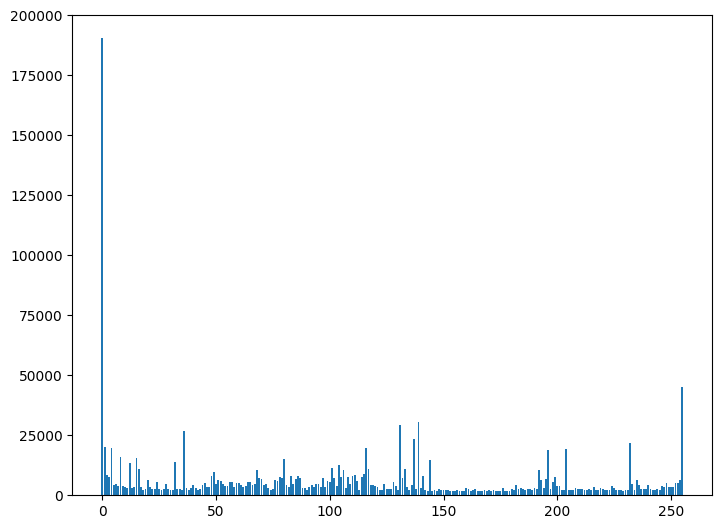

In [52]:
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x = range(256), height = byte_dict.values())
plt.show()

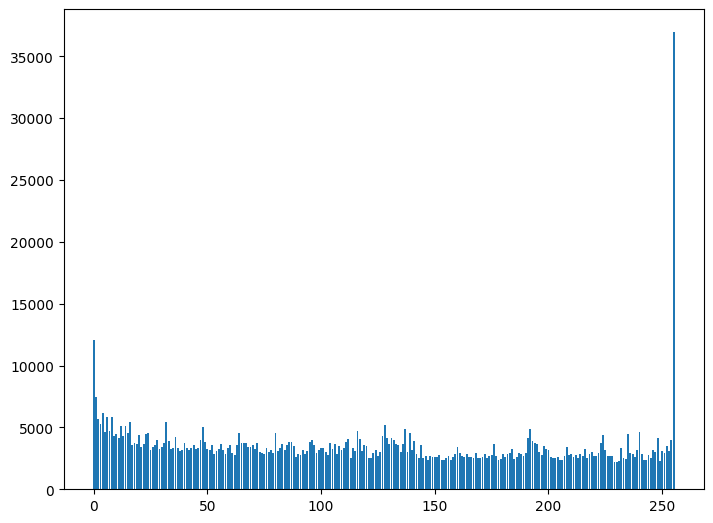

In [53]:
byte_packed_dict = countByte("putty32_packed.exe")
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(x = range(256), height = byte_packed_dict.values())
plt.show()

Question: why? Can you do bi-gram or tri-gram? Need to considering sliding window or not? How many grams needed? Can you find a way to do feature selection on these grams so that we do not need to keep so many features?

Take a look at this website!

https://github.com/packing-box/dataset-packed-pe


### ASM

https://www.capstone-engine.org/lang_python.html

In [54]:
!pip install capstone

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 12.5 MB/s eta 0:00:00


In [55]:
import capstone
import pefile

pef = pefile.PE("putty32.exe")
entryPoint = pef.OPTIONAL_HEADER.AddressOfEntryPoint
data = pef.get_memory_mapped_image()[entryPoint:]
cs = capstone.Cs(capstone.CS_ARCH_X86, capstone.CS_MODE_32)
for i in cs.disasm(data, 0x1000):
    print("0x%x:\t%s\t%s" %(i.address, i.mnemonic, i.op_str))

串流輸出內容已截斷至最後 5000 行。
0x7631:	add	dword ptr [esi + 0x10], 4
0x7635:	shr	eax, 4
0x7638:	test	al, 1
0x763a:	mov	eax, dword ptr [esi + 0x10]
0x763d:	je	0x7645
0x763f:	movsx	eax, byte ptr [eax - 4]
0x7643:	jmp	0x7649
0x7645:	movzx	eax, byte ptr [eax - 4]
0x7649:	cdq	
0x764a:	mov	ebx, eax
0x764c:	mov	eax, ecx
0x764e:	shr	eax, 4
0x7651:	test	al, 1
0x7653:	je	0x766b
0x7655:	cmp	edx, edi
0x7657:	jg	0x766b
0x7659:	jl	0x765f
0x765b:	cmp	ebx, edi
0x765d:	jae	0x766b
0x765f:	neg	ebx
0x7661:	adc	edx, edi
0x7663:	neg	edx
0x7665:	or	ecx, 0x40
0x7668:	mov	dword ptr [esi + 0x1c], ecx
0x766b:	cmp	dword ptr [esi + 0x24], 0
0x766f:	mov	dword ptr [ebp - 4], edx
0x7672:	jge	0x767d
0x7674:	mov	dword ptr [esi + 0x24], 1
0x767b:	jmp	0x7694
0x767d:	push	dword ptr [esi + 8]
0x7680:	and	ecx, 0xfffffff7
0x7683:	push	dword ptr [esi + 0x24]
0x7686:	mov	dword ptr [esi + 0x1c], ecx
0x7689:	lea	ecx, [esi + 0x3c]
0x768c:	call	0x7fb2
0x7691:	mov	edx, dword ptr [ebp - 4]
0x7694:	mov	eax, ebx
0x7696:	or	eax, edx
0x7698:	jne	

Note: we do not cover control-flow graph (CFG)!

## Fuzzy Hash

Get an older version.

In [56]:
!wget https://the.earth.li/~sgtatham/putty/0.75/w32/putty.exe -O putty32_old.exe

--2024-04-09 04:14:37--  https://the.earth.li/~sgtatham/putty/0.75/w32/putty.exe
Resolving the.earth.li (the.earth.li)... 93.93.131.124, 2a00:1098:86:4d:c0ff:ee:15:900d
Connecting to the.earth.li (the.earth.li)|93.93.131.124|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1179880 (1.1M) [application/x-msdos-program]
Saving to: ‘putty32_old.exe’

putty32_old.exe     100%[===================>]   1.12M  1.95MB/s    in 0.6s    

2024-04-09 04:14:38 (1.95 MB/s) - ‘putty32_old.exe’ saved [1179880/1179880]



In [57]:
!apt-get install ssdeep

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  ssdeep
0 upgraded, 1 newly installed, 0 to remove and 45 not upgraded.
Need to get 31.1 kB of archives.
After this operation, 85.0 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 ssdeep amd64 2.14.1+git20180629.57fcfff-2 [31.1 kB]
Fetched 31.1 kB in 0s (167 kB/s)
Selecting previously unselected package ssdeep.
(Reading database ... 121774 files and directories currently installed.)
Preparing to unpack .../ssdeep_2.14.1+git20180629.57fcfff-2_amd64.deb ...
Unpacking ssdeep (2.14.1+git20180629.57fcfff-2) ...
Setting up ssdeep (2.14.1+git20180629.57fcfff-2) ...
Processing triggers for man-db (2.10.2-1) ...


In [58]:
!ssdeep putty32.exe

ssdeep,1.1--blocksize:hash:hash,filename
24576:B14iA3zopo5mvLsBTQVNaGVQ/ZUpPS2CJDWQeC6WgQhpt8NsIH73yVpZItiaOt+t:cEjEsOUwngQhpilWFI2tO,"/content/putty32.exe"


In [59]:
!ssdeep putty32_old.exe

ssdeep,1.1--blocksize:hash:hash,filename
24576:uUqPzwjzLFgyYyAvnPfcBnrF3+Y8HB+g7lpuPv8S:SQ2/BcBnrFOlB3vuPt,"/content/putty32_old.exe"


In [60]:
import hashlib
print(hashlib.md5(open("putty32.exe", 'rb').read()).hexdigest())
print(hashlib.md5(open("putty32_old.exe", 'rb').read()).hexdigest())

1575e4f6e0f70b34b4d2ac25a2f3fadf
a993025aedf905cce301a176f3cd62fb


In [61]:
# https://www.fireeye.com/blog/threat-research/2014/01/tracking-malware-import-hashing.html

print(pefile.PE("putty32.exe").get_imphash())
print(pefile.PE("putty32_old.exe").get_imphash())

1bcee876dfae5e68c3451c29f9217c72
ddf7967f271d2def449d78bf72166fcb


Question: take a look at pefile's source code? What is imphash?

In [62]:
!ssdeep -pb *.exe

Note that python has "ssdeep", but it cannot install in colab directly. https://pypi.org/project/ssdeep/

In [63]:
!echo "This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pen." > b.txt

In [64]:
!ssdeep b.txt

ssdeep,1.1--blocksize:hash:hash,filename
3:hMCE3r4FMWF9eKE3r4FMWF9eKE3r4FMWF9eKE3r4FMWF5:hub4gfb4gfb4gfb41,"/content/b.txt"
ssdeep: Did not process files large enough to produce meaningful results


In [65]:
!echo "This is a book and that is a pen. This is a book and that is a pen. This is a book and that is a pineapple. This is a book and that is a pen" > a.txt

In [66]:
!ssdeep a.txt

ssdeep,1.1--blocksize:hash:hash,filename
3:hMCE3r4FMWF9eKE3r4FMWF9eKE3r4FMWFIHE3r4FMWFF:hub4gfb4gfb4hb4B,"/content/a.txt"
ssdeep: Did not process files large enough to produce meaningful results


# Microsoft Malware Classification Challenge (BIG 2015)


https://www.kaggle.com/competitions/malware-classification/overview

You are provided with a set of known malware files representing a mix of 9 different families. Each malware file has an Id, a 20 character hash value uniquely identifying the file, and a Class, an integer representing one of 9 family names to which the malware may belong:

* Ramnit
* Lollipop
* Kelihos_ver3
* Vundo
* Simda
* Tracur
* Kelihos_ver1
* Obfuscator.ACY
* Gatak


In [89]:
# get data from github

import requests

def download_request(url, out_name):
    response = requests.get(url)
    if response.status_code == 200:
        with open(out_name, 'wb') as f:
            f.write(response.content)
    else:
        print('Error: Failed to download the file')

In [ ]:
# sample from BIG 2015
url = 'https://github.com/hsiaom26/DS4CS-24/raw/main/data/dataSample.7z'
out_name = 'dataSample.7z'
download_request(url, out_name)

In [90]:
# label from BIG 2015
url = 'https://github.com/hsiaom26/DS4CS-24/raw/main/data/trainLabels.csv'
out_name = 'trainLabels.csv'
download_request(url, out_name)

In [83]:
!p7zip -d '/content/dataSample.7z'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 4261914 bytes (4163 KiB)

Extracting archive: /content/dataSample.7z
--
Path = /content/dataSample.7z
Type = 7z
Physical Size = 4261914
Headers Size = 266
Method = LZMA:26
Solid = +
Blocks = 1

  0%     41% - 0A32eTdBKayjCWhZqDOQ.asm                                75% 1 - 0ACDbR5M3ZhBJajygTuf.asm                                 Everything is Ok

Files: 4
Size:       60736584
Compressed: 4261914


In [85]:
!ls -al 0A*

-rw-r--r-- 1 root root 38495501 Jan 29  2015 0A32eTdBKayjCWhZqDOQ.asm
-rw-r--r-- 1 root root  4356052 Jan 29  2015 0A32eTdBKayjCWhZqDOQ.bytes
-rw-r--r-- 1 root root 12153703 Jan 29  2015 0ACDbR5M3ZhBJajygTuf.asm
-rw-r--r-- 1 root root  5731328 Jan 29  2015 0ACDbR5M3ZhBJajygTuf.bytes


In [97]:
!head -16 0A32eTdBKayjCWhZqDOQ.bytes

00401000 56 8D 44 24 08 50 8B F1 E8 1C 1B 00 00 C7 06 08
00401010 BB 42 00 8B C6 5E C2 04 00 CC CC CC CC CC CC CC
00401020 C7 01 08 BB 42 00 E9 26 1C 00 00 CC CC CC CC CC
00401030 56 8B F1 C7 06 08 BB 42 00 E8 13 1C 00 00 F6 44
00401040 24 08 01 74 09 56 E8 6C 1E 00 00 83 C4 04 8B C6
00401050 5E C2 04 00 CC CC CC CC CC CC CC CC CC CC CC CC
00401060 8B 44 24 08 8A 08 8B 54 24 04 88 0A C3 CC CC CC
00401070 8B 44 24 04 8D 50 01 8A 08 40 84 C9 75 F9 2B C2
00401080 C3 CC CC CC CC CC CC CC CC CC CC CC CC CC CC CC
00401090 8B 44 24 10 8B 4C 24 0C 8B 54 24 08 56 8B 74 24
004010A0 08 50 51 52 56 E8 18 1E 00 00 83 C4 10 8B C6 5E
004010B0 C3 CC CC CC CC CC CC CC CC CC CC CC CC CC CC CC
004010C0 8B 44 24 10 8B 4C 24 0C 8B 54 24 08 56 8B 74 24
004010D0 08 50 51 52 56 E8 65 1E 00 00 83 C4 10 8B C6 5E
004010E0 C3 CC CC CC CC CC CC CC CC CC CC CC CC CC CC CC
004010F0 33 C0 C2 10 00 CC CC CC CC CC CC CC CC CC CC CC


In [123]:
def bytesfile2hex(bytesfile, lines = 16):
  with open(bytesfile, 'rb') as f:
    arr = []
    while lines > 0:
      lines -= 1
      tokens = f.readline().split(b' ')[1:]
      tokens = [int(x.strip(), 16) for x in tokens]
      arr.append(tokens)
    return arr

In [127]:
arr = bytesfile2hex('/content/0A32eTdBKayjCWhZqDOQ.bytes')
print(arr)

[[86, 141, 68, 36, 8, 80, 139, 241, 232, 28, 27, 0, 0, 199, 6, 8], [187, 66, 0, 139, 198, 94, 194, 4, 0, 204, 204, 204, 204, 204, 204, 204], [199, 1, 8, 187, 66, 0, 233, 38, 28, 0, 0, 204, 204, 204, 204, 204], [86, 139, 241, 199, 6, 8, 187, 66, 0, 232, 19, 28, 0, 0, 246, 68], [36, 8, 1, 116, 9, 86, 232, 108, 30, 0, 0, 131, 196, 4, 139, 198], [94, 194, 4, 0, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204], [139, 68, 36, 8, 138, 8, 139, 84, 36, 4, 136, 10, 195, 204, 204, 204], [139, 68, 36, 4, 141, 80, 1, 138, 8, 64, 132, 201, 117, 249, 43, 194], [195, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204], [139, 68, 36, 16, 139, 76, 36, 12, 139, 84, 36, 8, 86, 139, 116, 36], [8, 80, 81, 82, 86, 232, 24, 30, 0, 0, 131, 196, 16, 139, 198, 94], [195, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204, 204], [139, 68, 36, 16, 139, 76, 36, 12, 139, 84, 36, 8, 86, 139, 116, 36], [8, 80, 81, 82, 86, 232, 101, 30, 0, 0, 131, 196, 16, 139, 198, 9

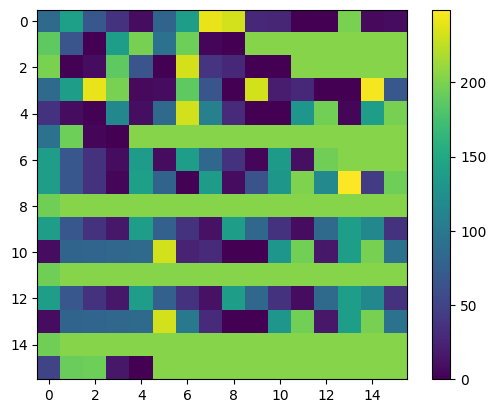

In [126]:
plt.figure()
plt.imshow(arr)
plt.colorbar()
plt.grid(False)
plt.show()

In [91]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [94]:
Y_df = pd.read_csv("/content/trainLabels.csv")

In [95]:
Y_df

,Id,Class
0,01kcPWA9K2BOxQeS5Rju,1
1,04EjIdbPV5e1XroFOpiN,1
2,05EeG39MTRrI6VY21DPd,1
3,05rJTUWYAKNegBk2wE8X,1
4,0AnoOZDNbPXIr2MRBSCJ,1
...,...,...
10863,KFrZ0Lop1WDGwUtkusCi,9
10864,kg24YRJTB8DNdKMXpwOH,9
10865,kG29BLiFYPgWtpb350sO,9
10866,kGITL4OJxYMWEQ1bKBiP,9


In [96]:
Y_df.Class.value_counts()

Class
3    2942
2    2478
1    1541
8    1228
9    1013
6     751
4     475
7     398
5      42
Name: count, dtype: int64

In [130]:
Y_df[Y_df.Id == '0A32eTdBKayjCWhZqDOQ']

,Id,Class
1553,0A32eTdBKayjCWhZqDOQ,2
